In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets
season_data = pd.read_csv('seasonstats.csv')  
matches_data = pd.read_csv('matches.csv')  


# Option 1: Drop rows with missing values
season_data_cleaned = season_data.dropna()
matches_data_cleaned = matches_data.dropna()

# Merging the datasets on 'Season'
merged_data = pd.merge(matches_data_cleaned, season_data_cleaned, on='Season')

# Encode the target variable
def determine_result(row):
    if row['Home Goals'] > row['Away Goals']:
        return 'Win'
    elif row['Home Goals'] < row['Away Goals']:
        return 'Lose'
    else:
        return 'Draw'

merged_data['Result'] = merged_data.apply(determine_result, axis=1)

# Selecting features for the model
features = ['xG', 'xG.1', 'Attendance', 'GF', 'GA']  # Include relevant features from the datasets
X = merged_data[features]
y = merged_data['Result']

# Encoding categorical variables
y = y.map({'Win': 0, 'Lose': 1, 'Draw': 2})  # Map results to integers

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)

# Function to predict the outcome based on two teams
def predict_match_result(home_team, away_team):
    match_data = merged_data[(merged_data['Home'] == home_team) & (merged_data['Away'] == away_team)]
    if match_data.empty:
        return "Match data not available."

    # Prepare input for the model
    input_data = match_data[features].mean().values.reshape(1, -1)
    probabilities = xgb_model.predict_proba(input_data)

    # Create a result mapping
    result_mapping = {0: 'Win', 1: 'Lose', 2: 'Draw'}
    
    # Calculate probabilities for both teams
    home_win_prob = probabilities[0][0]  # Home team winning
    away_win_prob = probabilities[0][1]   # Away team winning
    draw_prob = probabilities[0][2]        # Draw

    # Visualization
    fig, ax = plt.subplots()
    bars = ax.bar(['Home Win', 'Away Win', 'Draw'], [home_win_prob, away_win_prob, draw_prob],
                   color=['green', 'red', 'blue'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title(f'Predicted Match Outcome: {home_team} vs {away_team}')
    
    # Adding labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

    plt.show()
    
    return {
        f'{home_team} Win Probability': home_win_prob,
        f'{away_team} Win Probability': away_win_prob,
        'Draw Probability': draw_prob,
        'Predicted Result': result_mapping[np.argmax(probabilities)]
    }



C:\Users\HP\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


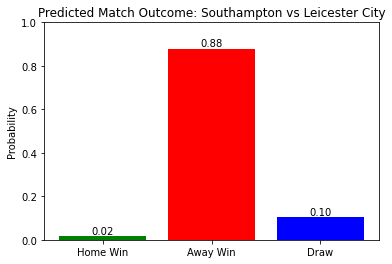

{'Southampton Win Probability': 0.017989064, 'Leicester City Win Probability': 0.8792452, 'Draw Probability': 0.1027657, 'Predicted Result': 'Lose', 'Predicted Home Goals': 0.22, 'Predicted Away Goals': 1.63}


In [7]:
home_team = "Southampton"  # Input your team name here
away_team = "Leicester City"  # Input your opponent team name here
result = predict_match_result(home_team, away_team)
print(result)